# Homework 2: Images
### By Carrick Coakley

In [7]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas
from rasterio.mask import mask
import pandas as pd
import numpy as np
import json
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.signal import medfilt2d


#Other packages from Wildfires lecture that may be important
##import pyproj
##import rasterstats

## Question 1:

"You will not be able to clip a raster to a vector file using the geopandas.clip  function. You instead have to use the rasterio.mask function. Look in the US Wildfires lecture for an example." 
-Prof

In [8]:
state_file = "Homework_2/us_states.json"

country = geopandas.read_file(state_file)

In [4]:
country.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


In [5]:
country.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

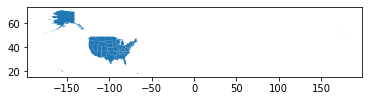

In [6]:
country.plot()

<AxesSubplot:>

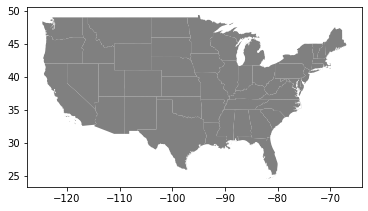

In [9]:
country = country[~country['NAME'].isin(["Alaska","Hawaii","Puerto Rico"])]

country.plot(color="Grey")

<AxesSubplot:>

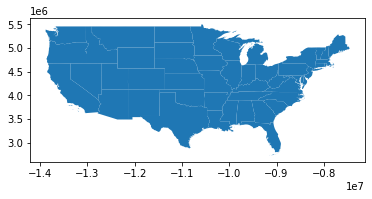

In [11]:
#Could need to reproject if user error (see wildfires) 
country_proj = country.to_crs(epsg=4087) # WGS 84 Equidistant Cylndrical
country_proj.plot()

<AxesSubplot:>

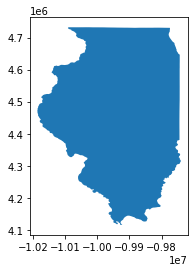

In [12]:
country_proj.head()
IL = country_proj[country_proj.NAME=="Illinois"]
IL.plot()

In [13]:
raster_file16 = "Homework_2/CDL_2016_clip.tif"

raster16 = rasterio.open(raster_file16)

In [14]:
raster16.crs==country_proj.crs

False

In [15]:
type(raster16.read()),raster16.read().shape

(numpy.ndarray, (1, 22306, 34385))

In [16]:
raster16.transform

Affine(30.0, 0.0, 337545.0,
       0.0, -30.0, 2223945.0)

In [17]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [18]:
src_file16 = raster_file16
dst_file16 = 'ppt_reproj.tif'
dst_crs16 = rasterio.crs.CRS.from_dict({'init': 'EPSG:4087'})

In [19]:
with rasterio.open(src_file16) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs16, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs16,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file16, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs16,
                resampling=Resampling.nearest)

In [20]:
raster16 = rasterio.open("./ppt_reproj.tif")

raster16.crs

CRS.from_epsg(4087)

In [21]:
ppt16 = raster16.read(1)
ppt16

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

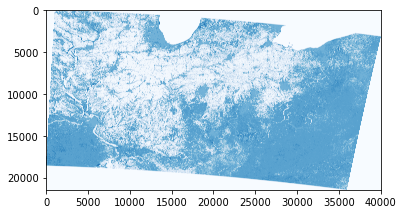

In [19]:
plt.imshow(ppt16,cmap="Blues")

In [22]:
json.loads(country_proj[country_proj.NAME=="Illinois"]['geometry'].to_json())['features'][0]['geometry']

{'type': 'Polygon',
 'coordinates': [[[-9948181.065135902, 4731108.860254603],
   [-9947683.467012053, 4731079.694548016],
   [-9939817.075195147, 4730950.675258187],
   [-9935349.04479318, 4730855.0518155955],
   [-9934927.477881545, 4730870.191266344],
   [-9932846.582640145, 4730860.951748608],
   [-9932622.941783143, 4730850.9329944365],
   [-9925994.75666233, 4730772.898031389],
   [-9925791.821230613, 4730783.028105051],
   [-9921361.973413985, 4730739.613503642],
   [-9920833.65111068, 4730743.50968582],
   [-9920453.383730132, 4730734.381487575],
   [-9918456.64602377, 4730688.62917686],
   [-9915354.060495872, 4730656.235205038],
   [-9912210.064117396, 4730661.4672211055],
   [-9908971.334852258, 4730643.8787415605],
   [-9908956.084082019, 4730642.7655466525],
   [-9906652.883817507, 4730635.975057715],
   [-9906617.484219434, 4730635.863738224],
   [-9901118.8579717, 4730534.451682111],
   [-9900799.037074652, 4730526.881956737],
   [-9900798.703116179, 4730526.881956737],


In [23]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

IL_coords = getFeatures(country_proj[country_proj.NAME=="Illinois"])

In [24]:
#added crop=True from class suggestion, delete if it messes it up
img_out, img_transform = mask(raster16,IL_coords, crop=True)

In [25]:
out_meta = raster16.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['transform'] = img_transform

with rasterio.open("./IL_PPT.tif", "w", **out_meta) as dest:
    dest.write(img_out)

In [26]:
IL_raster16 = rasterio.open("./IL_PPT.tif")

(4099999.9999999995, 4800000.0)

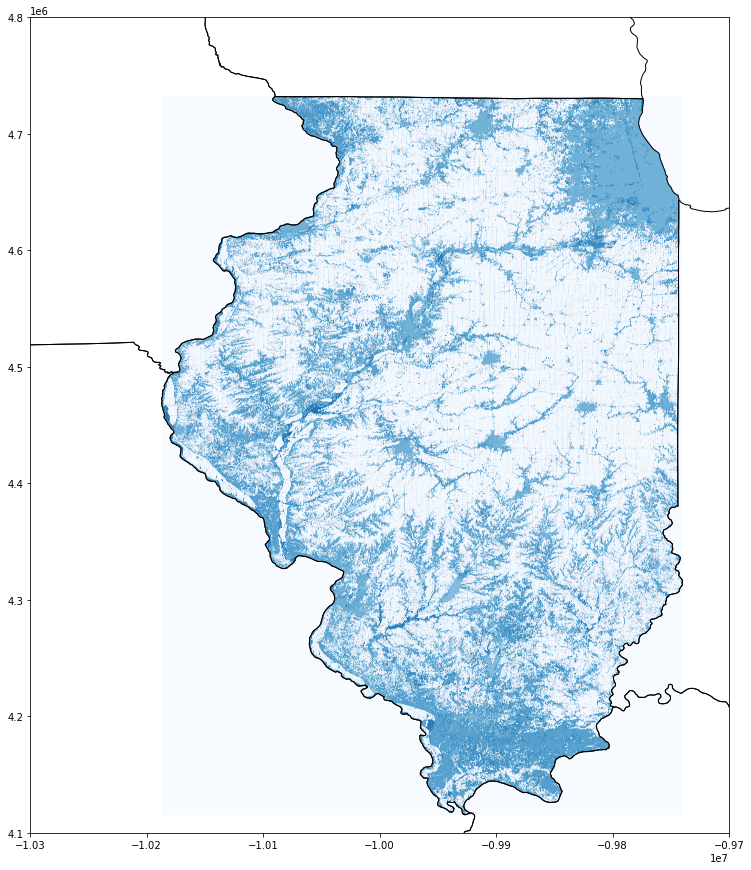

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster16, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(-1.03*10**7,-.97*10**7)
plt.ylim(4.1*10**6,4.8*10**6)

Now for 2017 clip:

In [27]:
raster_file17 = "Homework_2/CDL_2017_clip.tif"

raster17 = rasterio.open(raster_file17)

In [28]:
raster17.transform

Affine(30.0, 0.0, 337545.0,
       0.0, -30.0, 2223945.0)

In [29]:
src_file17 = raster_file17
dst_file17 = 'ppt_reproj2.tif'
dst_crs17 = rasterio.crs.CRS.from_dict({'init': 'EPSG:4087'})

In [30]:
with rasterio.open(src_file17) as src: 
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs17, src.width, src.height, *src.bounds) 
    kwargs = src.meta.copy() 
    kwargs.update({
        'crs': dst_crs17,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_file17, 'w', **kwargs) as dst: 
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs17,
                resampling=Resampling.nearest)

In [31]:
raster17 = rasterio.open("./ppt_reproj2.tif")

raster17.crs

CRS.from_epsg(4087)

In [32]:
#added crop=True from class suggestion, delete if it messes it up
img_out2, img_transform2 = mask(raster17,IL_coords, crop=True)

In [33]:
out_meta2 = raster17.meta.copy()

out_meta2['height'] = img_out2.shape[1]
out_meta2['width'] = img_out2.shape[2]
out_meta2['transform'] = img_transform2

with rasterio.open("./IL_PPT17.tif", "w", **out_meta2) as dest:
    dest.write(img_out2)

In [34]:
IL_raster17 = rasterio.open("./IL_PPT17.tif")

(4099999.9999999995, 4800000.0)

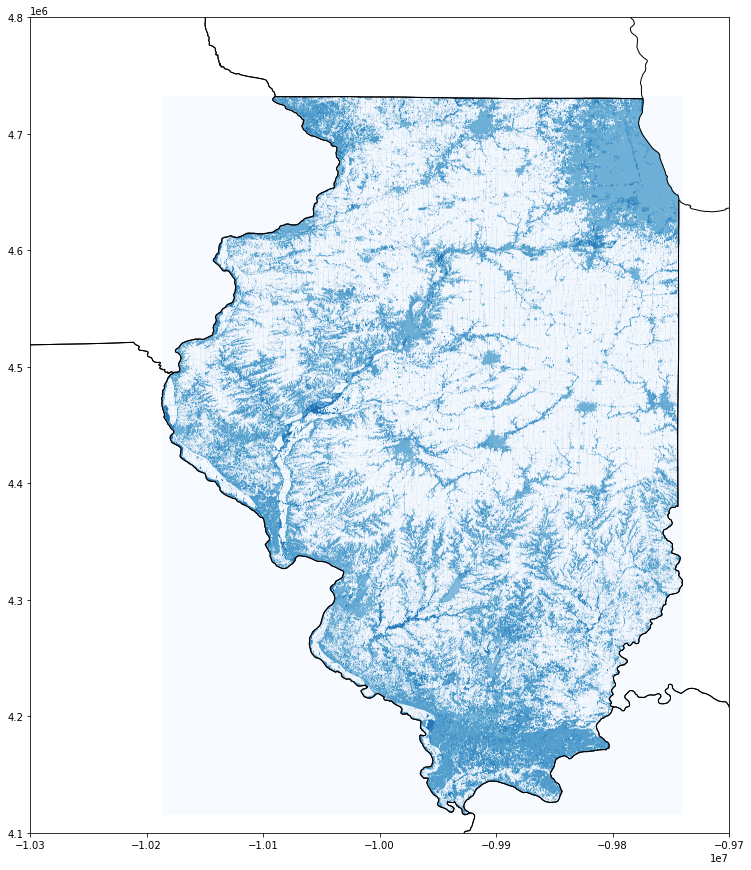

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))
rasterio.plot.show(IL_raster17, ax=ax,cmap="Blues")
country_proj.plot(ax=ax, facecolor='none', edgecolor='black')
plt.xlim(-1.03*10**7,-.97*10**7)
plt.ylim(4.1*10**6,4.8*10**6)

Looking at dataframes of raster files

In [ ]:
#does not work
#df17 = geopandas.read_file("Homework_2/CDL_2017_clip.tif")
#df17.head()

## Question 2

#this doesnt really work
import codecs
f = codecs.open('Homework_2/landuse.htm', 'r', 'utf-8')
landuse=f.read()
landuse=str(landuse)
landuse

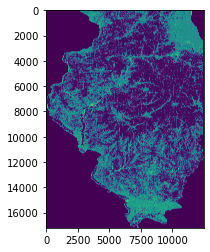

In [35]:
plt.imshow(IL_raster17.read(1))

In [36]:
IL_raster16_array=IL_raster16.read(1)

In [37]:
#for soy section in question 3
#housespendcopy=copy.deepcopy(housespend)
import copy
IL_raster16_array_soycopy=copy.deepcopy(IL_raster16_array)

In [38]:
IL_raster17_array=IL_raster17.read(1)

In [39]:
IL_raster17_array_soycopy=copy.deepcopy(IL_raster17_array)

In [37]:
pixels16 = pd.Series(IL_raster16_array.flatten())
pixels16=pixels16[pixels16!=0]
pixels16

15194        111
15195        111
15196        111
15197        111
15198        111
            ... 
214814749    111
214827226    111
214827227    111
214827228    111
214827229    111
Length: 148793803, dtype: uint8

In [37]:
pixels17 = pd.Series(IL_raster17_array.flatten())
pixels17=pixels17[pixels17!=0]
pixels17

15194        111
15195        111
15196        111
15197        111
15198        111
            ... 
214814749    111
214827226    111
214827227    111
214827228    111
214827229    111
Length: 148793803, dtype: uint8

In [ ]:
pixel_counts16=pixels16.value_counts()
pixel_counts16.head(10)

In [59]:
pixel_counts17=pixels17.value_counts()
pixel_counts17.head(10)

1      46407890
5      41181367
141    23243078
176    12961218
122     7082484
121     6703870
111     2654158
123     2501899
190     1706174
26      1159789
dtype: int64

In [49]:
import codecs
landusefile='Homework_2/landuse.htm'
f = codecs.open(landusefile, 'r', 'utf-8')
landuse=f.read()
landuse

'<!DOCTYPE html>\r\n<html lang="en">\r\n<html>\r\n<head>\r\n  <meta charset="UTF-8"/>\r\n  <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n  <meta name="viewport" content="width=device-width, initial-scale=1"/>\r\n  <title>2017 Illinois Cropland Data Layer | NASS/USDA</title>\r\n  \r\n  <meta name="dc.title" content="2017 Illinois Cropland Data Layer | NASS/USDA "/>\r\n  <meta name="dc.creator" content="United States Department of Agriculture (USDA), National Agricultural Statistics Service (NASS), Research and Development Division (RDD), Geospatial Information Branch (GIB), Spatial Analysis Research Section (SARS) "/>\r\n  <meta name="dc.subject" content="farming, 001 environment, 007 imageryBaseMapsEarthCover, 010 "/>\r\n  <meta name="dc.description" content="The USDA, NASS Cropland Data Layer (CDL) is a raster, geo-referenced, crop-specific land cover data layer. The 2017 CDL has a ground resolution of 30 meters. The CDL is produced using satellite imagery from the Landsat 

In [52]:
from bs4 import BeautifulSoup

In [54]:
soup = BeautifulSoup(landuse, 'html.parser')
table = soup.find_all("pre")
Land_Use_Data = table[1:]
pd.read_html(str(Land_Use_Data))[0]

[<pre>
 USDA, National Agricultural Statistics Service, 2017 Illinois Cropland Data Layer
 STATEWIDE AGRICULTURAL ACCURACY REPORT
 
 Crop-specific covers only  *Correct  Accuracy     Error     Kappa
 -------------------------   -------  --------    ------     -----
 OVERALL ACCURACY**           581731     89.0%     11.0%     0.805
 
 
 Cover                       Attribute  *Correct Producer's  Omission             User's Commission   Cond'l
 Type                             Code    Pixels  Accuracy     Error     Kappa  Accuracy     Error     Kappa
 ----                             ----    ------  --------     -----     -----  --------     -----     -----
 Corn                                1    296780     92.0%      8.0%     0.884     96.0%      4.0%     0.941
 Rice                                3         1      4.3%     95.7%     0.043    100.0%      0.0%     1.000
 Sorghum                             4        50     11.6%     88.4%     0.116     53.8%     46.2%     0.537
 Soybeans

I don't think next three lines are necessary; renames soup and opens a different way. Few lines above seem to do the same thing

In [56]:
import requests
url = 'https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_il17.htm'
#http://quickstats.nass.usda.gov/api/api_GET/?key=api key&commodity_desc=CORN&year__GE=2012&state_alpha=IL&format=JSON
params = {}
r = requests.get(url)


r.status_code

200

In [57]:
r.text

'<!DOCTYPE html>\r\n<html lang="en">\r\n<html>\r\n<head>\r\n  <meta charset="UTF-8"/>\r\n  <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n  <meta name="viewport" content="width=device-width, initial-scale=1"/>\r\n  <title>2017 Illinois Cropland Data Layer | NASS/USDA</title>\r\n  \r\n  <meta name="dc.title" content="2017 Illinois Cropland Data Layer | NASS/USDA "/>\r\n  <meta name="dc.creator" content="United States Department of Agriculture (USDA), National Agricultural Statistics Service (NASS), Research and Development Division (RDD), Geospatial Information Branch (GIB), Spatial Analysis Research Section (SARS) "/>\r\n  <meta name="dc.subject" content="farming, 001 environment, 007 imageryBaseMapsEarthCover, 010 "/>\r\n  <meta name="dc.description" content="The USDA, NASS Cropland Data Layer (CDL) is a raster, geo-referenced, crop-specific land cover data layer. The 2017 CDL has a ground resolution of 30 meters. The CDL is produced using satellite imagery from the Landsat 

In [60]:
soup = BeautifulSoup(r.text,'html.parser')

In [61]:
Top_10_Land_Uses = ['Corn', 'Soybean', 'Decidous Forest', 'Grassland/Pasture', 'Developed/Low Intensity', 'Developed/Open Space', 'Open Water', 'Developed/Med Intensity', 'Woody Wetlands', 'Dbl Crop WinWht/Soybeans']
Top_10_Land_Uses

['Corn',
 'Soybean',
 'Decidous Forest',
 'Grassland/Pasture',
 'Developed/Low Intensity',
 'Developed/Open Space',
 'Open Water',
 'Developed/Med Intensity',
 'Woody Wetlands',
 'Dbl Crop WinWht/Soybeans']

#### Following markdowns are either failures or methods to get computer to solve for most common land uses, above is just a manual list

df=pd.read_csv(r'cdlcsv.csv')
df.to_json(r'cdl.json')

with open("cdl.json") as f:
    pixel_names = json.load(f)

pixellist=list(pixel_names.items())
pixellkeys=list(pixel_names.keys())
pixellvalues=list(pixel_names.values())
pixellvalues

pixel_names=df['Crop']
#df['Crop']

pixel_ixs = pd.Series(pixel_counts.index).astype(str)
pixel_ixs.replace(pixel_names).head(10)

pixel_counts.index = pixel_names
pixel_counts.head(10)

# Question 3 

In [35]:
#Start 2016 Corn
corn_mask = IL_raster16_array==1
IL_raster16_array[~corn_mask]=0

NameError: name 'IL_raster16_array' is not defined

In [67]:
img_out = np.zeros(IL_raster16_array.shape)
img_out[corn_mask] = 1
img_out = img_out[np.newaxis,:,:].astype(np.uint8)

#Noah put: out_meta = IL_2017_raster.meta.copy()
#Don't know why he used 2017 for 2016 portion
out_meta = IL_raster16.meta.copy()

out_meta['height'] = img_out.shape[1]
out_meta['width'] = img_out.shape[2]
out_meta['dtype'] = 'uint8'
#Noah put: out_meta['transform'] = IL_2017_raster.transform
out_meta['transform'] = IL_raster16.transform

with rasterio.open('./corn_2016_layer.tif', 'w', **out_meta) as dest:
    dest.write(img_out)

In [68]:
corn_2016 = rasterio.open('./corn_2016_layer.tif')
pd.Series(corn_2016.read(1).flatten()).value_counts()

0    167294162
1     47538268
dtype: int64

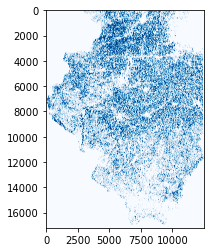

In [69]:
#2016 Corn Plot
plt.imshow(corn_2016.read(1).astype(float), cmap="Blues")

In [71]:
#Start 2017 Corn
corn_mask17 = IL_raster17_array==1
IL_raster17_array[~corn_mask17]=0

img_out17 = np.zeros(IL_raster17_array.shape)
img_out17[corn_mask17] = 1
img_out17 = img_out17[np.newaxis,:,:].astype(np.uint8)

out_meta17 = IL_raster17.meta.copy()

out_meta17['height'] = img_out.shape[1]
out_meta17['width'] = img_out.shape[2]
out_meta17['dtype'] = 'uint8'

out_meta17['transform'] = IL_raster17.transform

with rasterio.open('./corn_2017_layer.tif', 'w', **out_meta17) as dest:
    dest.write(img_out17)

In [72]:
corn_2017 = rasterio.open('./corn_2017_layer.tif')
pd.Series(corn_2017.read(1).flatten()).value_counts()

0    168424540
1     46407890
dtype: int64

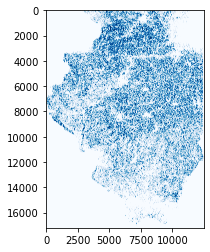

In [73]:
#2017 Corn Plot
plt.imshow(corn_2017.read(1).astype(float), cmap="Blues")

In [94]:
#Start 2016 Soy
soy_mask = IL_raster16_array_soycopy==5
IL_raster16_array_soycopy[~soy_mask]=0

In [95]:
img_outs16 = np.zeros(IL_raster16_array_soycopy.shape)
img_outs16[soy_mask] = 5
img_outs16 = img_outs16[np.newaxis,:,:].astype(np.uint8)

out_metas16 = IL_raster16.meta.copy()

out_metas16['height'] = img_outs16.shape[1]
out_metas16['width'] = img_outs16.shape[2]
out_metas16['dtype'] = 'uint8'

out_metas16['transform'] = IL_raster16.transform

with rasterio.open('./soy_2016_layer.tif', 'w', **out_metas16) as dest:
    dest.write(img_outs16)

In [96]:
soy_2016 = rasterio.open('./soy_2016_layer.tif')
pd.Series(soy_2016.read(1).flatten()).value_counts()

0    175353103
5     39479327
dtype: int64

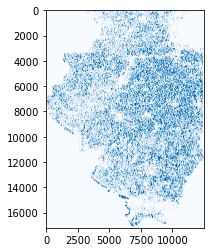

In [97]:
# 2016 Soybean Plot
plt.imshow(soy_2016.read(1).astype(float), cmap="Blues")

In [98]:
#Start 2017 Soy
soy_mask17 = IL_raster17_array_soycopy==5
IL_raster17_array_soycopy[~soy_mask17]=0
img_outs17 = np.zeros(IL_raster17_array_soycopy.shape)
img_outs17[soy_mask17] = 5
img_outs17 = img_outs17[np.newaxis,:,:].astype(np.uint8)

out_metas17 = IL_raster17.meta.copy()

out_metas17['height'] = img_outs17.shape[1]
out_metas17['width'] = img_outs17.shape[2]
out_metas17['dtype'] = 'uint8'

out_metas17['transform'] = IL_raster17.transform

with rasterio.open('./soy_2017_layer.tif', 'w', **out_metas17) as dest:
    dest.write(img_outs17)
soy_2017 = rasterio.open('./soy_2017_layer.tif')
pd.Series(soy_2017.read(1).flatten()).value_counts()

0    173651063
5     41181367
dtype: int64

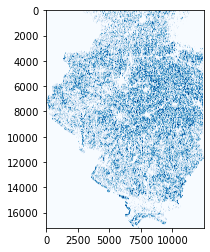

In [99]:
# 2017 Soybean Plot
plt.imshow(soy_2017.read(1).astype(float), cmap="Blues")

# Question 4
Describe degree of crop rotation between 2016 and 2017 corn and soy bean

In [40]:
def raster_cs(raster,filename):
    x = raster.read(1)
    img_out = np.zeros(x.shape) # 0 for other
    
    corn_mask = x==1
    soy_mask = x==5
    
    img_out[corn_mask] = 1 # 1 for crops
    img_out[soy_mask] = 2 # 2 for fallow
    
    img_out = img_out[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = raster.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = raster.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [41]:
cs16 = raster_cs(IL_raster16,"cs16")
cs17 = raster_cs(IL_raster17,"cs17")

In [42]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.colors

labels = {0:"Other",
          1:"Corn",
          2:"Soy"}

cmap = matplotlib.colors.ListedColormap(['white', "C3","C0"])

patches =[mpatches.Patch(color=cmap(i),label=labels[i]) for i in labels.keys()]

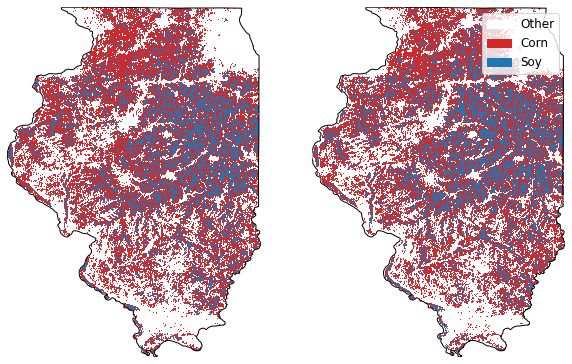

In [111]:
fig, ax = plt.subplots(1,2,figsize=(10, 10))

# 2017
rasterio.plot.show(cs16,cmap=cmap,ax=ax[0])
IL.plot(ax=ax[0], facecolor='none', edgecolor='black')
ax[0].axis('off')

# 2018
rasterio.plot.show(cs17,cmap=cmap,ax=ax[1])
IL.plot(ax=ax[1], facecolor='none', edgecolor='black')
ax[1].axis('off')

plt.legend(handles=patches,fontsize=12)

In [43]:
def visualize_rotate(y1,y2,filename):
    a1 = y1.read(1)
    a2 = y2.read(1)
    
    C_to_C = (a1==1)&(a2==1)
    C_to_S = (a1==1)&(a2==2)
    S_to_C = (a1==2)&(a2==1)
    S_to_S = (a1==2)&(a2==2)
    
    a = np.zeros(a1.shape)
    
    a[C_to_C] = 1
    a[C_to_S] = 2
    a[S_to_C] = 3
    a[S_to_S] = 4
    
    img_out = a[np.newaxis,:,:].astype(np.uint8)
    
    out_meta = y1.meta.copy()

    out_meta['height'] = img_out.shape[1]
    out_meta['width'] = img_out.shape[2]
    out_meta['transform'] = y1.transform
    out_meta['dtype'] = "uint8"

    with rasterio.open("./"+filename+".tif", "w", **out_meta) as dest:
        dest.write(img_out)
    
    return rasterio.open("./"+filename+".tif")

In [44]:
rotate_labels = {0:"Background",
                 1:"Corn to Corn",
                 2:"Corn to Soy",
                 3:"Soy to Corn",
                 4:"Soy to Soy"}
cs_16_17 = visualize_rotate(cs16,cs17,"cs_16_17")
rotate_counts = pd.Series(cs_16_17.read(1).flatten()).value_counts().iloc[1:]
rotate_counts.index = pd.Series(rotate_counts.index).replace(rotate_labels)
rotate_counts/rotate_counts.sum()*100

Corn to Soy     40.636887
Soy to Corn     38.173080
Corn to Corn    14.453159
Soy to Soy       6.736874
dtype: float64

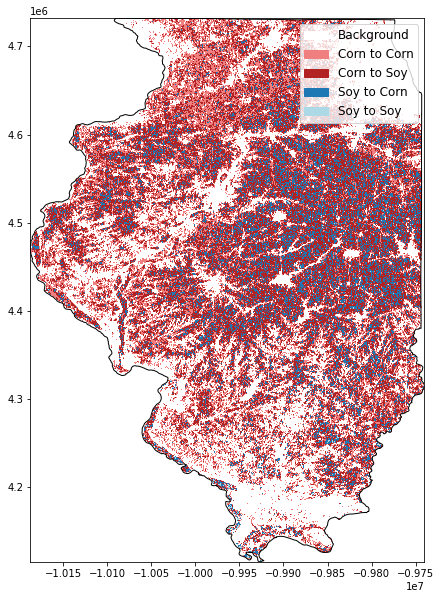

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))

cmap = matplotlib.colors.ListedColormap(["white","lightcoral","firebrick", 'C0','lightblue'])

patches =[mpatches.Patch(color=cmap(i),label=rotate_labels[i]) for i in rotate_labels.keys()]

# Plot 2017-2018
rasterio.plot.show(cs_16_17 ,cmap=cmap,ax=ax)
IL.plot(ax=ax, facecolor='none', edgecolor='black')
#ax.set_xlim(-123,-118.5)
#ax.set_ylim(34.8,40.5)
# ax.axis("off")

plt.legend(handles=patches,fontsize=12)